# Using NetworkX for connectivity metrics



In [1]:
%%capture
# Install dotmotif with one line.
# On your own computer, you can run this in the terminal.
!pip3 install dotmotif networkx
import numpy as np
import networkx as nx
from dotmotif import Motif, GrandIsoExecutor
import pandas
from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt
from scipy.stats import ranksums
import statsmodels.stats.multitest as smm



In [2]:

from lsmm_data import LSMMData
import json

with open('v1dd_data_structures_information.json') as f:
    loaded_json = json.load(f)
my_data = LSMMData.LSMMData(loaded_json)
tables = my_data.data
params = my_data.params
dirs = my_data.dirs
mappings = my_data.mappings
 
print(tables['structural']['pre_cell'])
print(tables['structural']['post_cell'])
print(tables['structural']['synapse'])
 
pt_root_id = tables['structural']['pre_cell'].iloc[1]['pt_root_id']

Filtering to 10 cells per type
Generating Connectome...


100%|██████████| 132646/132646 [03:54<00:00, 565.31it/s]


Generating Connectome...


100%|██████████| 132646/132646 [04:13<00:00, 523.04it/s]


     index      id          pt_root_id  pt_position_x  pt_position_y  \
0        9  293764  864691132625300120         878665         697702   
1       41  295576  864691132710501931         842193         737122   
2       62  278405  864691132830575876         737898         601710   
3       85  307952  864691132999200949         867646         840563   
4       93  366542  864691132834421640         923130         760946   
..     ...     ...                 ...            ...            ...   
812   8764  371302  864691132849454803         958050         629957   
813   8769  385115  864691132679146333         975354         850418   
814   8773  383491  864691132763271347         928872         797418   
815   8790  351167  864691132579592205         927863         548865   
816   8794  277788  864691132653866455         853833         547235   

     pt_position_z classification_system cell_type status_axon  \
0           245475            excitatory        4P    extended   
1  

In [4]:
'''def calc_ground_truth(pre_cells, synapse, post_cells, use_sizes=False):
    pre_cell_pt_index = pre_cells['pt_root_id']
    post_cell_pt_index = post_cells['pt_root_id']
    synapses = synapse[(synapse['pre_pt_root_id'].isin(pre_cells['pt_root_id'])) & (synapse['post_pt_root_id'].isin(post_cells['pt_root_id']))]
    pre_cell_pt_index = pre_cell_pt_index.to_list()
    post_cell_pt_index = post_cell_pt_index.to_list()

    synapse_connectome = np.zeros((len(pre_cells), len(post_cells)))
    for synapse in tqdm(range(len(synapses))):
        preidx = pre_cell_pt_index.index(synapses.iloc[synapse]['pre_pt_root_id'])
        postidx = post_cell_pt_index.index(synapses.iloc[synapse]['post_pt_root_id'])
        if use_sizes:
            synapse_connectome[preidx,postidx] += synapses.iloc[synapse]['size']
        else:
            synapse_connectome[preidx,postidx] += 1
    return synapse_connectome'''

In [10]:
cell_table = tables['structural']['pre_cell']

weight_matrix = tables['structural']['summed_size_connectome']


adjacency_matrix = weight_matrix.clip(0,1)
#np.fill_diagonal(adjacency_matrix, 0)
all_to_all_graph = nx.from_numpy_array(adjacency_matrix, create_using=nx.DiGraph)

In [11]:
test = nx.to_numpy_array(all_to_all_graph)
test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [12]:
np.mean(adjacency_matrix - test)

0.0

#**NETWORKX METRICS CHECK**

In [13]:
# Calculate metrics
CC = nx.average_clustering(all_to_all_graph)  # clustering coefficient

L = nx.average_shortest_path_length(all_to_all_graph)  # Average shortest path length

# Generate a random graph with the same number of nodes and edges
G_rand = nx.gnm_random_graph(all_to_all_graph.number_of_nodes(), all_to_all_graph.number_of_edges(), directed=True)

# Calculate random metrics
CC_rand = nx.average_clustering(G_rand)  # Random clustering coefficient
L_rand = nx.average_shortest_path_length(G_rand.to_directed())  # Random average shortest path length

# Calculate small-worldness
sigma = (CC / CC_rand) * (L_rand / L)


# Print results
print("Out-degree Clustering Coefficient (CC_out):", CC)
#print("In-degree Clustering Coefficient (CC_in):", CC_in)
print("Average Shortest Path Length (L):", L)
print("Random Clustering Coefficient (CC_rand):", CC_rand)
print("Random Average Shortest Path Length (L_rand):", L_rand)
print("Small-Worldness (σ):", sigma)

NetworkXError: Graph is not strongly connected.

#CENTRALITY: 
Degree centrality, in-degree centrality, out-degree centrality, closeness centrality

In [15]:
centrality = nx.degree_centrality(all_to_all_graph)
indegree_centrality = nx.in_degree_centrality(all_to_all_graph)
outdegree_centrality = nx.out_degree_centrality(all_to_all_graph)
closeness_centrality = nx.closeness_centrality(all_to_all_graph)
betweeness_centrality = nx.betweenness_centrality(all_to_all_graph, normalized= True)

In [16]:
cell_table['centrality'] = centrality
cell_table['indegree_centrality'] = indegree_centrality
cell_table['outdegree_centrality'] = outdegree_centrality #normalized in networkx
cell_table['closeness_centrality'] = closeness_centrality 
cell_table['betweeness_centrality'] = betweeness_centrality

In [17]:
node_total = len(all_to_all_graph.nodes())

In [18]:
assemblies_by_connectome_index = mappings['assemblies_by_connectome_index']    #Assembly number for the cell in the connectome

In [19]:
assemblies_by_connectome_index

{361: ['A 1'],
 288: ['A 1', 'A 3', 'A 4', 'A 5', 'A 7', 'A 8'],
 9: ['A 1'],
 604: ['A 1', 'A 5', 'A 7', 'A 10'],
 439: ['A 1', 'A 3'],
 117: ['A 1'],
 717: ['A 1', 'A 4', 'A 7', 'A 8'],
 153: ['A 1', 'A 4', 'A 7', 'A 8'],
 212: ['A 1', 'A 2', 'A 8'],
 515: ['A 1', 'A 3'],
 670: ['A 1'],
 411: ['A 1', 'A 3', 'A 5'],
 636: ['A 1', 'A 2', 'A 3'],
 338: ['A 1', 'A 6'],
 407: ['A 1'],
 116: ['A 1', 'A 4'],
 190: ['A 1', 'A 6'],
 25: ['A 1', 'A 3', 'A 4'],
 802: ['A 1', 'A 2'],
 314: ['A 1', 'A 6'],
 730: ['A 1', 'A 3', 'A 8'],
 65: ['A 2', 'A 11'],
 101: ['A 2'],
 435: ['A 2'],
 698: ['A 2', 'A 10'],
 767: ['A 2', 'A 4', 'A 5'],
 375: ['A 2', 'A 10'],
 289: ['A 3'],
 216: ['A 3', 'A 7', 'A 8'],
 358: ['A 3'],
 50: ['A 4'],
 632: ['A 4'],
 772: ['A 4', 'A 5', 'A 7', 'A 8'],
 152: ['A 4', 'A 5', 'A 7', 'A 8'],
 684: ['A 5', 'A 7'],
 230: ['A 5'],
 810: ['A 6'],
 540: ['A 9', 'A 12'],
 607: ['A 9'],
 69: ['A 10'],
 696: ['A 10'],
 679: ['A 13', 'A 15'],
 284: ['A 14'],
 573: ['No A'],
 242: 

In [20]:
def get_indices_and_assemblies(assemblies_by_connectome_index):
   cells_index = []    #connectome index of cell
   assembly_id = []    #assembly id

   for cell in assemblies_by_connectome_index:
      cells_index.append(cell)

   for assembly in assemblies_by_connectome_index.values():
      assembly_id.append(assembly)
   '''for assembly in cell_indices_by_assemblies:
       for cell in cell_indices_by_assemblies[assembly]:
        cells_index.append(cell)
        assembly_id.append(assembly)'''

   return cells_index, assembly_id



In [21]:

cell_idx, assembly_id = get_indices_and_assemblies(assemblies_by_connectome_index)

#sort the indices and assembly id - make a new dataframe
cell_index_and_assembly = pandas.DataFrame()
cell_index_and_assembly['cell_index'] = cell_idx
cell_index_and_assembly['assembly_id'] = assembly_id

In [22]:
cell_index_and_assembly


,cell_index,assembly_id
0,361,[A 1]
1,288,"[A 1, A 3, A 4, A 5, A 7, A 8]"
2,9,[A 1]
3,604,"[A 1, A 5, A 7, A 10]"
4,439,"[A 1, A 3]"
5,117,[A 1]
6,717,"[A 1, A 4, A 7, A 8]"
7,153,"[A 1, A 4, A 7, A 8]"
8,212,"[A 1, A 2, A 8]"
9,515,"[A 1, A 3]"


In [ ]:
#cell_index_and_assembly = cell_index_and_assembly.groupby('cell_index')['assembly_id'].apply(list).reset_index()

In [23]:

def get_assemblyIndex_for_Connectome_cells(cell_table, cell_index_and_assembly):
 connectome_assembly_id = []   #assembly id for all the cells in a connectome
 #non_assembly_cell_in_connectome = []
 #assembly_cell_not_in_connectome = []
 assembly_cell=[]   #a cell that is present in an assembly-------derived from assemblies by connectome index
 for i in range(len(cell_table)):
     connectome_assembly_id.append([])      
 assembly_id_for_cells_in_assemblies = []
 cells_in_assemblies = []   #connectome cells that belong to an assembly
 for cellIndex, assemblyMembershiplist in zip(cell_index_and_assembly['cell_index'],cell_index_and_assembly['assembly_id']):
  for index, cell in enumerate(cell_table['connectome_index']):
    if cellIndex == cell:
      connectome_assembly_id[index] = assemblyMembershiplist      #add the assembly id to the empty list at that connectome index
      assembly_id_for_cells_in_assemblies.append(assemblyMembershiplist)     #this should be equal to cell_index_and_assembly['assembly_id'] 
      cells_in_assemblies.append(cell)   #this should be equal to cell_index_and_assembly['cell_index'] ---- value from cell_table
      assembly_cell.append(cellIndex)    #should match with cells_in_assemblies---- value from 'table'
  
 #return(connectome_assembly_id, assembly_id_for_cells_in_assemblies, cells_in_assemblies, assembly_cell)

 return(connectome_assembly_id)


In [24]:
connectome_assembly_id = get_assemblyIndex_for_Connectome_cells(cell_table, cell_index_and_assembly)



In [25]:
cell_table['assembly_id'] = connectome_assembly_id #add assembly id for each cell in the connectome to the main cell table


In [26]:
cell_table['assembly_id'][284]

['A 14']

In [27]:
cell_table['assembly_id'][83] #[check]

['No A']

In [86]:
#TRIAL CHECK FOR 'AND' 'OR' LOGIC
''''cells = ['A 1', 'A 1', 'A 1', 'A 1','0']

for idx in cells:
    print(idx != 'A 1')
    print(idx != '0')
    print(idx != 'A 1' or idx != '0')
    print(idx != 'A 1' and idx != '0')'''


False
True
True
False
False
True
True
False
False
True
True
False
False
True
True
False
True
False
True
False


In [108]:
#TEST CODE
'''
for idx, cent in zip(cell_table['connectome_index'], cell_table['centrality']):  #note- check the exact functionality of ZIP function
    if idx in mappings['assemblies_by_connectome_index'].keys():
        if mappings['assemblies_by_connectome_index'][idx] == ['No A']:
            print(idx, mappings['assemblies_by_connectome_index'][idx], cent)
            #APPEND CENTRALITY!'''

32 ['No A'] 0.1605392156862745
83 ['No A'] 0.11764705882352941
221 ['No A'] 0.18504901960784315
242 ['No A'] 0.17892156862745098
363 ['No A'] 0.15318627450980393
402 ['No A'] 0.11397058823529412
464 ['No A'] 0.1409313725490196
573 ['No A'] 0.11764705882352941
731 ['No A'] 0.16176470588235295
737 ['No A'] 0.13725490196078433
766 ['No A'] 0.0821078431372549
774 ['No A'] 0.13112745098039216


In [110]:
cell_table['centrality'][83]  #correct!

0.11764705882352941

This shows that OR will always be TRUE!

In [127]:
#plots

#----------DEGREE CENTRALITY------------------------
centrality_assembly_cells = []
centrality_non_assembly_cells = []
id_check_non_assembly = []

for id, cent in zip(cell_table['assembly_id'], cell_table['centrality']):
  if id != ['No A'] and id != []:    
   #print(idx)
   #print(idx)
   centrality_assembly_cells.append(cent)
  elif id == ['No A']:
    #print(idx)
    #print(cent)
    id_check_non_assembly.append(id)
    centrality_non_assembly_cells.append(cent)



In [128]:
for i in id_check_non_assembly:
    if i != ['No A']:
        print(i)

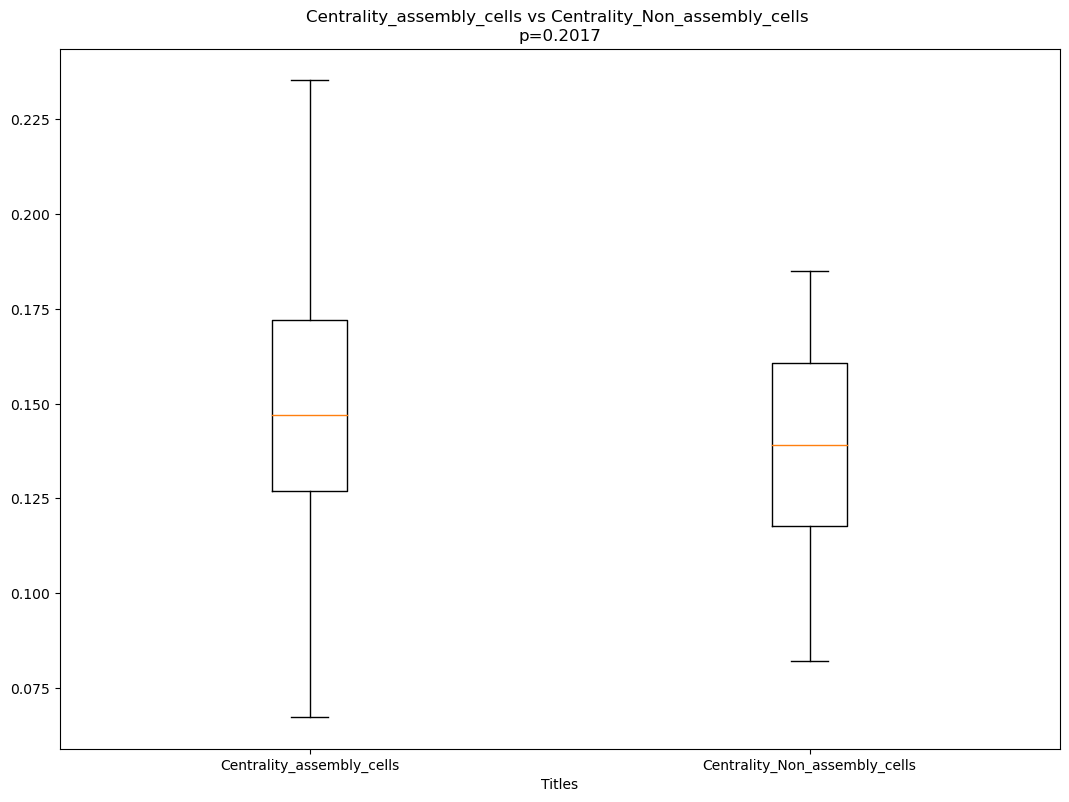

In [129]:
import matplotlib.pyplot as plt
from scipy.stats import ranksums

data = [centrality_assembly_cells, centrality_non_assembly_cells]

stat, p_value = ranksums(centrality_assembly_cells, centrality_non_assembly_cells, 'greater')

titles = ['Centrality_assembly_cells', 'Centrality_Non_assembly_cells']

fig = plt.figure(figsize =(10, 7))

# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])

# Creating plot
bp = ax.boxplot(data)

# show plot
ax.set_xticklabels(titles)

# Set the x-axis label
plt.xlabel('Titles')
plt.title(f'{titles[0]} vs {titles[1]} \np={p_value:.4f}')
plt.show()

In [130]:
#---------------------------------plots for in-degree------------------------------------

indegree_centrality_assembly_cells = []
indegree_centrality_non_assembly_cells = []
idx_check_assembly_ID = []
idx_check_non_assembly_ID = []

for id, in_cent, conn_idx in zip(cell_table['assembly_id'], cell_table['indegree_centrality'], cell_table['connectome_index']):
  if  id != ['No A'] and id != []:    
   #print(idx, conn_idx)
   idx_check_assembly_ID.append(conn_idx)
   indegree_centrality_assembly_cells.append(in_cent)
  elif id == ['No A']:
    
    #print(idx, conn_idx)
    #print(cent)
    idx_check_non_assembly_ID.append(conn_idx)
    indegree_centrality_non_assembly_cells.append(in_cent)

print("No. of assembly cells:", len(idx_check_assembly_ID))
print("No. of non-assembly cells:", len(idx_check_non_assembly_ID))

No. of assembly cells: 43
No. of non-assembly cells: 12


In [131]:
len(idx_check_non_assembly_ID)

12

In [132]:
np.shape(cell_table['assembly_id'])

(817,)

In [133]:
np.shape(cell_table['connectome_index'])

(817,)

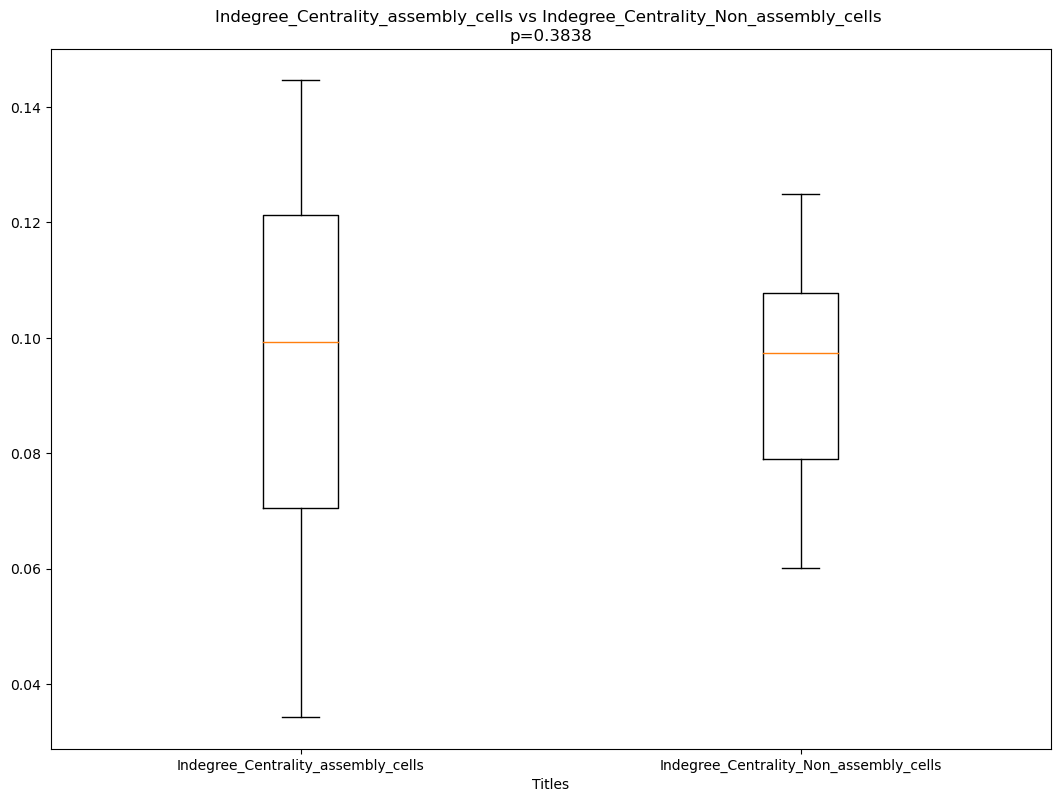

In [134]:
data = [indegree_centrality_assembly_cells, indegree_centrality_non_assembly_cells]

stat, p_value = ranksums(indegree_centrality_assembly_cells, indegree_centrality_non_assembly_cells, 'greater')

titles = ['Indegree_Centrality_assembly_cells', 'Indegree_Centrality_Non_assembly_cells']

fig = plt.figure(figsize =(10, 7))

# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])

# Creating plot
bp = ax.boxplot(data)

# show plot
ax.set_xticklabels(titles)

# Set the x-axis label
plt.xlabel('Titles')
plt.title(f'{titles[0]} vs {titles[1]} \np={p_value:.4f}')
plt.show()

In [34]:
cell_table

,index,id,pt_root_id,pt_position_x,pt_position_y,pt_position_z,classification_system,cell_type,status_axon,pt_position_x_trafo,...,full_dendrite,cell_type_v2,connectome_index,pt_position,centrality,indegree_centrality,outdegree_centrality,closeness_centrality,betweeness_centrality,assembly_id
0,9,293764,864691132625300120,878665,697702,245475,excitatory,4P,extended,-17654.153169,...,True,4P,0,"[878665, 697702, 245475]",0.079657,0.049020,0.030637,0.460408,0.000085,[]
1,41,295576,864691132710501931,842193,737122,325260,inhibitory,ProxTC,extended,-67856.489452,...,True,ProxTC-L5,1,"[842193, 737122, 325260]",0.095588,0.058824,0.036765,0.484525,0.000405,[]
2,62,278405,864691132830575876,737898,601710,294075,inhibitory,DistTC,extended,-145995.980100,...,True,DistTC-L23,2,"[737898, 601710, 294075]",0.327206,0.156863,0.170343,0.497252,0.002206,[]
3,85,307952,864691132999200949,867646,840563,262935,excitatory,5P,extended,-69027.465946,...,True,5P,3,"[867646, 840563, 262935]",0.083333,0.044118,0.039216,0.474636,0.000507,[]
4,93,366542,864691132834421640,923130,760946,173250,inhibitory,DistTC,extended,17492.220187,...,False,DistTC-L4,4,"[923130, 760946, 173250]",0.232843,0.066176,0.166667,0.471066,0.002077,[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
812,8764,371302,864691132849454803,958050,629957,382545,inhibitory,ProxTC,extended,67043.559779,...,True,ProxTC-L4,812,"[958050, 629957, 382545]",0.417892,0.145833,0.272059,0.507482,0.003332,[]
813,8769,385115,864691132679146333,975354,850418,394650,excitatory,6P,extended,17544.597851,...,True,6P,813,"[975354, 850418, 394650]",0.056373,0.031863,0.024510,0.436462,0.000134,[]
814,8773,383491,864691132763271347,928872,797418,316125,excitatory,5P,extended,3578.299784,...,True,5P,814,"[928872, 797418, 316125]",0.100490,0.064951,0.035539,0.483948,0.000349,[]
815,8790,351167,864691132579592205,927863,548865,192105,inhibitory,ProxTC,extended,51726.443534,...,False,ProxTC-L23,815,"[927863, 548865, 192105]",0.371324,0.148284,0.223039,0.504650,0.002343,[]


In [154]:
#---------------------plots for out-degree---------------------------------

outdegree_centrality_assembly_cells = []
outdegree_centrality_non_assembly_cells = []
idx_check_assembly_OD = []
idx_check_non_assembly_OD = []

for id, out_cent, conn_idx in zip(cell_table['assembly_id'], cell_table['outdegree_centrality'], cell_table['connectome_index']):
  if  id != ['No A'] and id != []:    
   #print(idx, conn_idx)
   idx_check_assembly_OD.append(conn_idx)
   outdegree_centrality_assembly_cells.append(out_cent)
  elif id == ['No A']:
    #print(idx)
    #print(cent)
    idx_check_non_assembly_OD.append(conn_idx)
    outdegree_centrality_non_assembly_cells.append(out_cent)

print("No. of assembly cells:", len(idx_check_assembly_OD))
print("No. of non-assembly cells:", len(idx_check_non_assembly_OD))

No. of assembly cells: 43
No. of non-assembly cells: 12


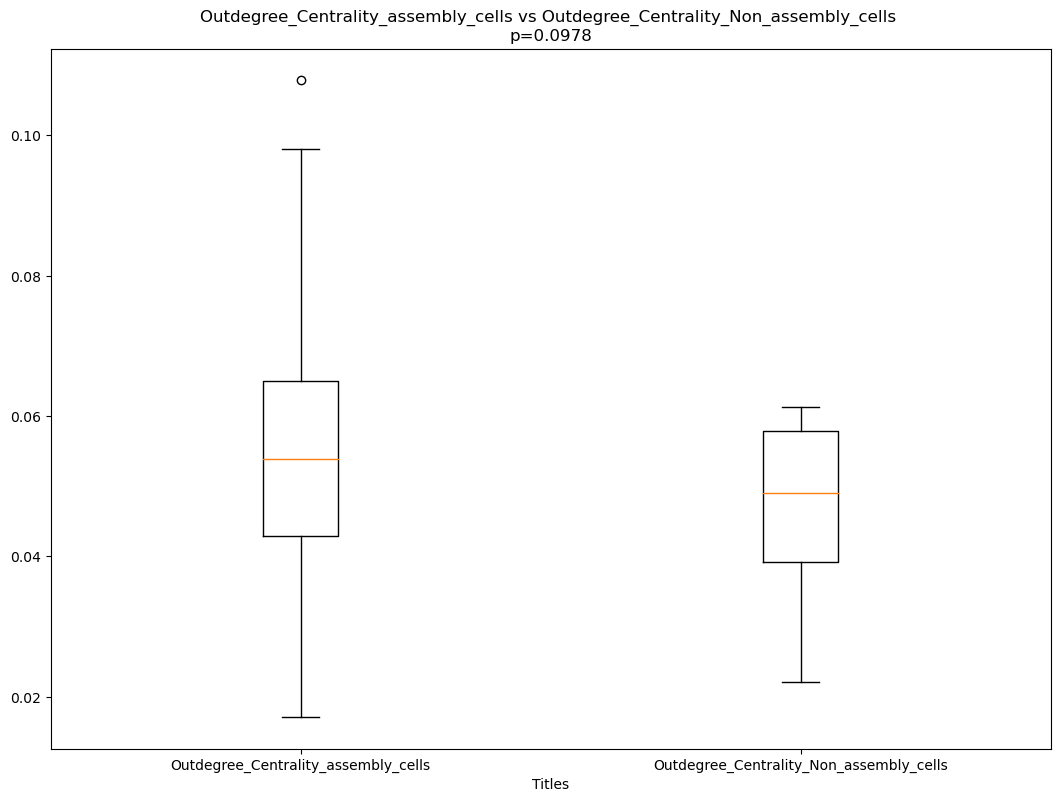

In [155]:
data = [outdegree_centrality_assembly_cells, outdegree_centrality_non_assembly_cells]

stat, p_value = ranksums(outdegree_centrality_assembly_cells, outdegree_centrality_non_assembly_cells, 'greater')
# print(np.mean(outdegree_centrality_assembly_cells))
# print(np.mean(outdegree_centrality_non_assembly_cells))
# print(np.std(outdegree_centrality_assembly_cells))
# print(np.std(outdegree_centrality_non_assembly_cells))
titles = ['Outdegree_Centrality_assembly_cells', 'Outdegree_Centrality_Non_assembly_cells']

fig = plt.figure(figsize =(10, 7))

# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])

# Creating plot
bp = ax.boxplot(data)

# show plot
ax.set_xticklabels(titles)

# Set the x-axis label
plt.xlabel('Titles')
plt.title(f'{titles[0]} vs {titles[1]} \np={p_value:.4f}')
plt.show()

In [156]:
#statistical test
stat = ranksums(outdegree_centrality_assembly_cells, outdegree_centrality_non_assembly_cells)
stat.pvalue

0.19565388621461488

In [157]:
closeness_centrality_assembly_cells = []
closeness_centrality_non_assembly_cells = []
id_check_non_assembly = []

for id, close_cent in zip(cell_table['assembly_id'], cell_table['closeness_centrality']):
  if id != ['No A'] and id != []:    
   #print(idx)
   #print(idx)
   closeness_centrality_assembly_cells.append(close_cent)
  elif id == ['No A']:
    #print(idx)
    #print(cent)
    id_check_non_assembly.append(id)
    closeness_centrality_non_assembly_cells.append(close_cent)

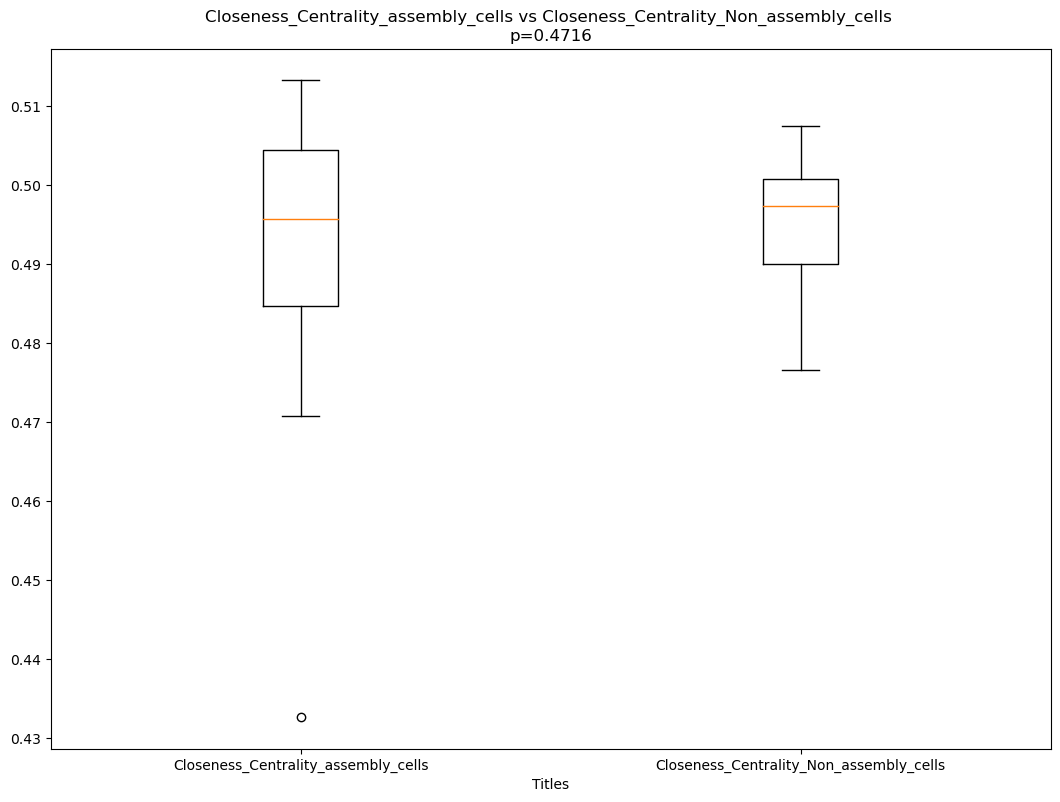

In [158]:
#-----------------------------plot for closeness centrality ----------------------------------
data = [closeness_centrality_assembly_cells, closeness_centrality_non_assembly_cells]

stat, p_value = ranksums(closeness_centrality_assembly_cells, closeness_centrality_non_assembly_cells, 'greater')
titles = ['Closeness_Centrality_assembly_cells', 'Closeness_Centrality_Non_assembly_cells']

fig = plt.figure(figsize =(10, 7))

# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])

# Creating plot
bp = ax.boxplot(data)

# show plot
ax.set_xticklabels(titles)

# Set the x-axis label
plt.xlabel('Titles')
plt.title(f'{titles[0]} vs {titles[1]} \np={p_value:.4f}')
plt.show()

In [159]:
#stat test
stat = ranksums(closeness_centrality_assembly_cells, closeness_centrality_non_assembly_cells)
stat.pvalue

0.9431393572120192

In [164]:
#plots

#----------DEGREE CENTRALITY------------------------
b_centrality_assembly_cells = []
b_centrality_non_assembly_cells = []
idx_check_assembly_BC= []
idx_check_non_assembly_BC = []


for id, bet_cent, conn_idx in zip(cell_table['assembly_id'], cell_table['betweeness_centrality'], cell_table['connectome_index']):
  if id != ['No A'] and id != []:    
   #print(idx)
   idx_check_assembly_BC.append(conn_idx)
   b_centrality_assembly_cells.append(bet_cent)
  elif id == ['No A']:
    #print(idx)
    #print(cent)
    idx_check_non_assembly_BC.append(conn_idx)
    b_centrality_non_assembly_cells.append(bet_cent)

print("No. of assembly cells:", len(idx_check_assembly_BC))
print("No. of non-assembly cells:", len(idx_check_non_assembly_BC))

No. of assembly cells: 43
No. of non-assembly cells: 12


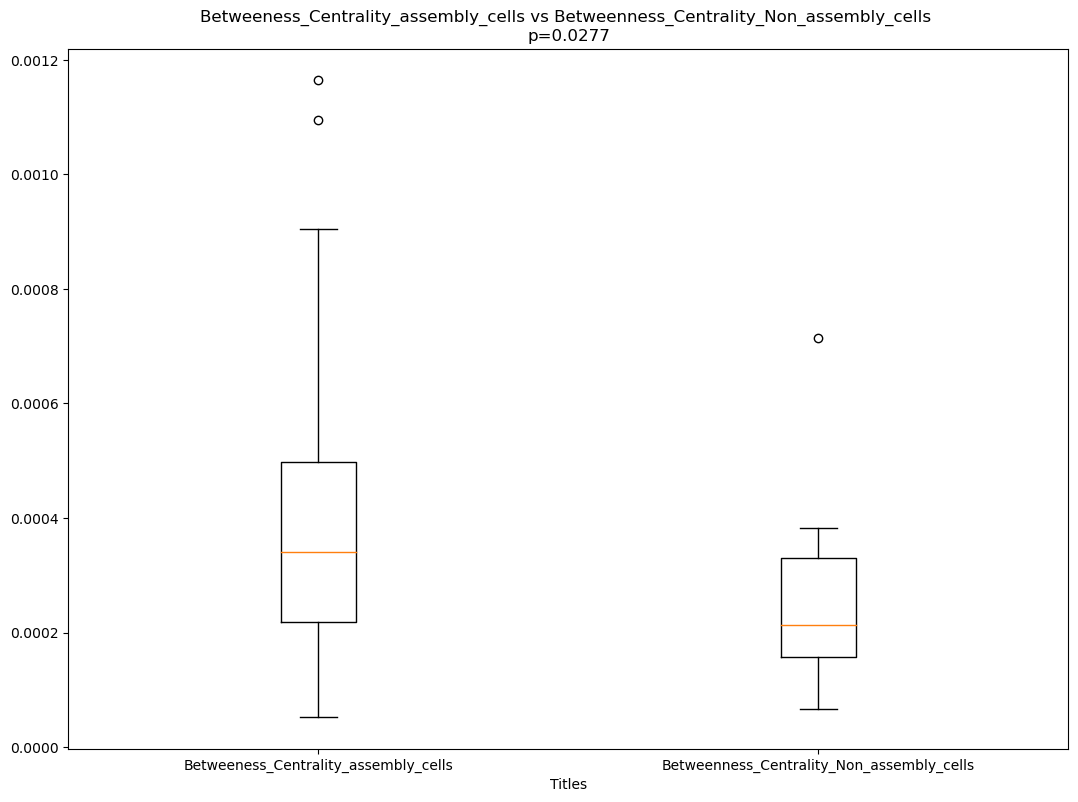

In [165]:
#-----------------------------plot for closeness centrality ----------------------------------
data = [b_centrality_assembly_cells, b_centrality_non_assembly_cells]

stat, p_value = ranksums(b_centrality_assembly_cells,b_centrality_non_assembly_cells, 'greater')
titles = ['Betweeness_Centrality_assembly_cells', 'Betweenness_Centrality_Non_assembly_cells']

fig = plt.figure(figsize =(10, 7))

# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])

# Creating plot
bp = ax.boxplot(data)

# show plot
ax.set_xticklabels(titles)

# Set the x-axis label
plt.xlabel('Titles')
plt.title(f'{titles[0]} vs {titles[1]} \np={p_value:.4f}')
plt.show()

**RE-CHECK CENTRALITY**

In [7]:
mappings['assemblies_by_connectome_index'].keys()

dict_keys([361, 288, 9, 604, 439, 117, 717, 153, 212, 515, 670, 411, 636, 338, 407, 116, 190, 25, 802, 314, 730, 65, 101, 435, 698, 767, 375, 289, 216, 358, 50, 632, 772, 152, 684, 230, 810, 540, 607, 69, 696, 679, 284, 573, 242, 363, 731, 737, 221, 32, 402, 464, 766, 774, 83])

To check if the indexes from cell table assemblies check in for loops: "for idx, out_cent, conn_idx in zip(cell_table['assembly_id'], cell_table['indegree_centrality'], cell_table['connectome_index'])" are matching in mappings

In [166]:
check_index = []
for i, cell in enumerate(cell_table['assembly_id']):
    if cell != []:
     check_index.append((cell_table['connectome_index'][i]))

In [167]:
#for betweenness centrality
for i, val in enumerate(idx_check_assembly_BC):
    if val not in mappings['assemblies_by_connectome_index'].keys():  #checked for both "in" and  "not in"
        print(i, val)

for i, val in enumerate(idx_check_non_assembly_BC):
    if val not in mappings['assemblies_by_connectome_index'].keys():
        print(i, val)

In [168]:
#for outdegree centrality
for i, val in enumerate(idx_check_assembly_OD):
    if val in mappings['assemblies_by_connectome_index'].keys():
        print(i, val)

for i, val in enumerate(idx_check_non_assembly_OD):
    if val in mappings['assemblies_by_connectome_index'].keys():
        print(i, val)

0 9
1 25
2 50
3 65
4 69
5 101
6 116
7 117
8 152
9 153
10 190
11 212
12 216
13 230
14 284
15 288
16 289
17 314
18 338
19 358
20 361
21 375
22 407
23 411
24 435
25 439
26 515
27 540
28 604
29 607
30 632
31 636
32 670
33 679
34 684
35 696
36 698
37 717
38 730
39 767
40 772
41 802
42 810
0 32
1 83
2 221
3 242
4 363
5 402
6 464
7 573
8 731
9 737
10 766
11 774


In [101]:
mappings['connectome_indexes_by_assembly']['No A'].sort()

In [104]:
mappings['connectome_indexes_by_assembly']['No A']

[32, 83, 221, 242, 363, 402, 464, 573, 731, 737, 766, 774]

Checks without adding the assembly id's to cell_table

In [170]:
bet_cent_assembly_check = []
bet_cent_non_assembly_check = []
for idx, cent in zip(cell_table['connectome_index'], cell_table['betweeness_centrality']):  #note- check the exact functionality of ZIP function
    if idx in mappings['assemblies_by_connectome_index'].keys():
        if mappings['assemblies_by_connectome_index'][idx] == ['No A']:
            bet_cent_non_assembly_check.append(cent)
        if mappings['assemblies_by_connectome_index'][idx] != ['No A']:
            bet_cent_assembly_check.append(cent)

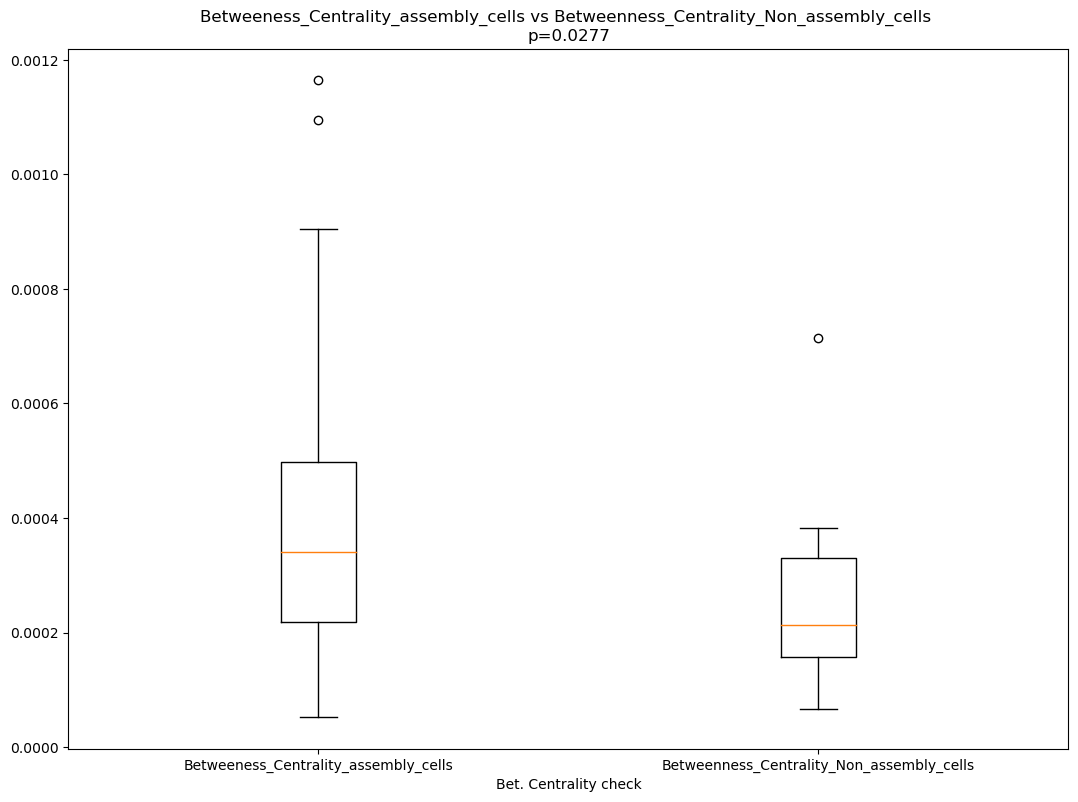

In [171]:
#-----------------------------plot for closeness centrality ----------------------------------
data = [bet_cent_assembly_check, bet_cent_non_assembly_check]

stat, p_value = ranksums(bet_cent_assembly_check,bet_cent_non_assembly_check, 'greater')
titles = ['Betweeness_Centrality_assembly_cells', 'Betweenness_Centrality_Non_assembly_cells']

fig = plt.figure(figsize =(10, 7))

# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])

# Creating plot
bp = ax.boxplot(data)

# show plot
ax.set_xticklabels(titles)

# Set the x-axis label
plt.xlabel('Bet. Centrality check')
plt.title(f'{titles[0]} vs {titles[1]} \np={p_value:.4f}')
plt.show()

In [172]:
out_cent_assembly_check = []
out_cent_non_assembly_check = []
for idx, cent in zip(cell_table['connectome_index'], cell_table['outdegree_centrality']):  #note- check the exact functionality of ZIP function
    if idx in mappings['assemblies_by_connectome_index'].keys():
        if mappings['assemblies_by_connectome_index'][idx] == ['No A']:
            out_cent_non_assembly_check.append(cent)
        if mappings['assemblies_by_connectome_index'][idx] != ['No A']:
            out_cent_assembly_check.append(cent)

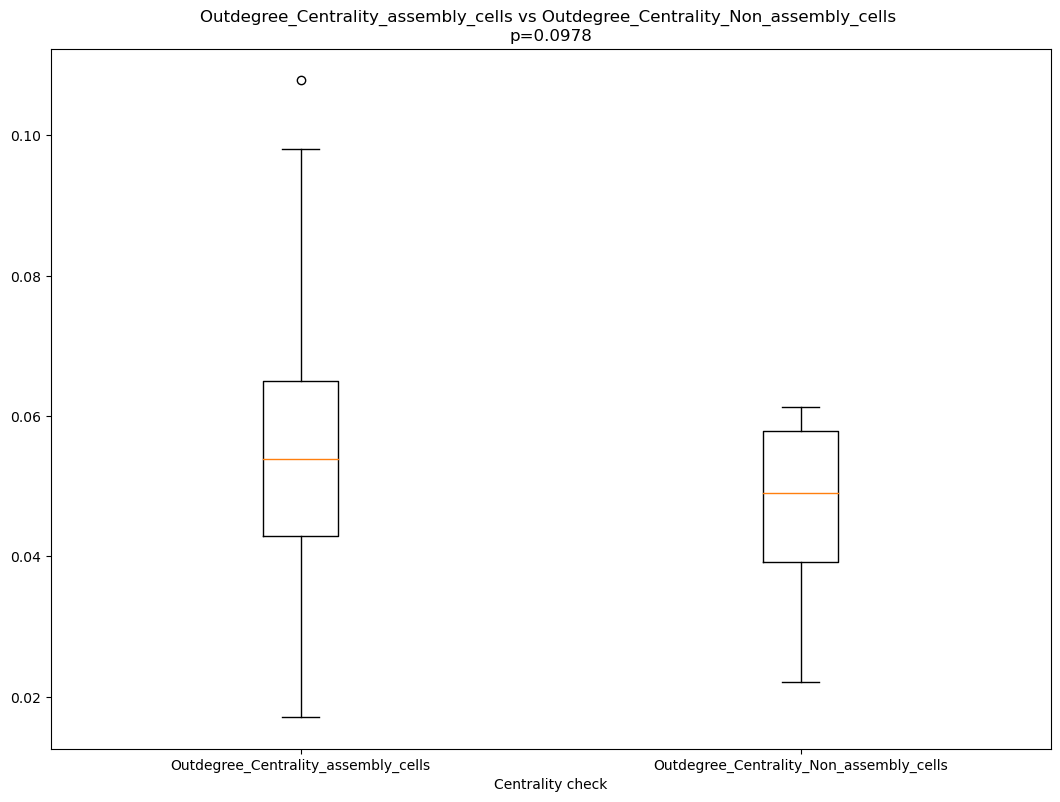

In [173]:
#-----------------------------plot for closeness centrality ----------------------------------
data = [out_cent_assembly_check, out_cent_non_assembly_check]

stat, p_value = ranksums(out_cent_assembly_check,out_cent_non_assembly_check, 'greater')
titles = ['Outdegree_Centrality_assembly_cells', 'Outdegree_Centrality_Non_assembly_cells']

fig = plt.figure(figsize =(10, 7))

# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])

# Creating plot
bp = ax.boxplot(data)

# show plot
ax.set_xticklabels(titles)

# Set the x-axis label
plt.xlabel('Centrality check')
plt.title(f'{titles[0]} vs {titles[1]} \np={p_value:.4f}')
plt.show()